In [1]:
import torchaudio
import torchaudio.functional as F_audio
import torchaudio.transforms as T_audio

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
from torchdata.datapipes.iter import FileOpener, HttpReader, IterableWrapper
from torch.utils.data import DataLoader
import functools
import os
import librosa
import numpy as np

import warnings
import glob
import io
from joblib import delayed 
import fma.utils as fma

from cacher import root, file_cached, mem_cached, clear_cache
from utils import ProgressParallel, plot_waveform, plot_spectrogram, plot_fbank, plot_mel_fbank
from data_loader import read_wavs

from IPython.display import Audio, display

from spectrogrammer import Spectrogramer
import matplotlib.pyplot as plt

SAMPLE_RATE = 4096
LENGTH_SECONDS = 1.0
LENGTH = int(round((LENGTH_SECONDS * SAMPLE_RATE)))
wavs = read_wavs("small", SAMPLE_RATE, LENGTH_SECONDS, LENGTH)
wavs = Tensor(wavs)
print("wavs.shape=", wavs.shape)

N_FFT = 1024
WIN_LENGTH = None
HOP_LENGTH = 512
N_MELS = 128
spectrogrammer = Spectrogramer(sample_rate = SAMPLE_RATE,
              n_fft = N_FFT,
              win_length = WIN_LENGTH,
              hop_length = HOP_LENGTH,
              n_mels = N_MELS)
x = spectrogrammer.wave2mel(wavs)
print("x (spectrogram of wavs).shape=", x.shape)

wavs.shape= torch.Size([7996, 4096])
x (spectrogram of wavs).shape= torch.Size([7996, 128, 9])


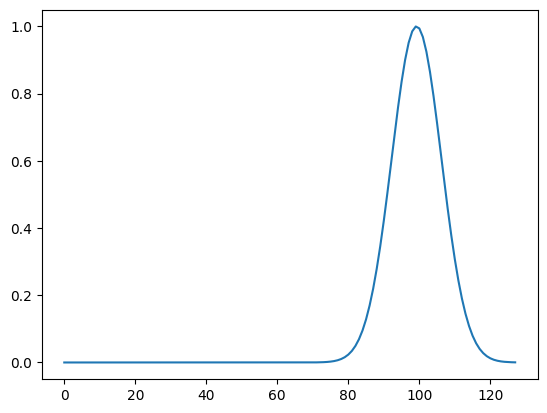

In [10]:
def nd_based_filter(N, centers):
    cnt = centers.shape[0]
    x = torch.linspace(0, N, N, device=centers.device).repeat(cnt, 1)
    centers = centers.repeat(N, 1).T
    d = 10
    return torch.e ** (-((x - centers) / d) ** 2)

plt.plot(nd_based_filter(N_MELS, torch.Tensor([10, 50, 100]))[2])

[0/1000]	 loss: 106.5226 loss_test: 130.2356  lr: 0.0100  accurancy: 9.1720 
[1/1000]	 loss: 130.2356 loss_test: 69.8361  lr: 0.0100  accurancy: 6.2880 
[2/1000]	 loss: 69.8361 loss_test: 128.7267  lr: 0.0100  accurancy: 9.5194 
[3/1000]	 loss: 128.7267 loss_test: 324.9892  lr: 0.0100  accurancy: 16.3269 
[4/1000]	 loss: 324.9892 loss_test: 41.7473  lr: 0.0100  accurancy: 4.7043 
[5/1000]	 loss: 41.7473 loss_test: 25.6315  lr: 0.0100  accurancy: 3.8449 
[6/1000]	 loss: 25.6315 loss_test: 162.8803  lr: 0.0100  accurancy: 10.9932 
[7/1000]	 loss: 162.8803 loss_test: 34.9604  lr: 0.0100  accurancy: 3.3599 
[8/1000]	 loss: 34.9604 loss_test: 24.7615  lr: 0.0100  accurancy: 3.0817 
[9/1000]	 loss: 24.7615 loss_test: 34.2026  lr: 0.0100  accurancy: 4.7217 
[10/1000]	 loss: 34.2026 loss_test: 75.5977  lr: 0.0100  accurancy: 7.0981 
[11/1000]	 loss: 75.5977 loss_test: 27.9884  lr: 0.0100  accurancy: 3.8703 
[12/1000]	 loss: 27.9884 loss_test: 7.0029  lr: 0.0100  accurancy: 1.6508 
[13/1000]	 l

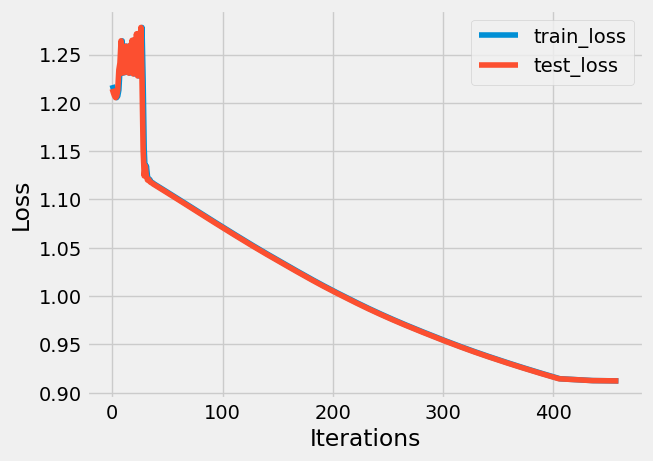

In [45]:
# nn.Tanhshrink(),
# nn.Sigmoid(),
# nn.ReLU(),

import importlib
import trainer_mod
import tuner

importlib.reload(trainer_mod)
importlib.reload(tuner)
Trainer = trainer_mod.Trainer

def remap(val, old_0, old_1, new_0, new_1):
    return (val - old_0) / (old_1 - old_0) * (new_1 - new_0) + new_0

def suggest_activation(name, trial):
    cat = trial.suggest_categorical(name, ["tanh", "relu", "leakyrelu", "sigmoid"])
    if cat == "tanh":
        return nn.Tanh()
    elif cat == "relu":
        return nn.ReLU(True)
    elif cat == "leakyrelu":
        return nn.LeakyReLU(trial.suggest_float("leakyrelu",0.01, 0.01, 0.1, log=True))
    elif cat == "sigmoid":
        return nn.Sigmoid() 

class Autoencoder(nn.Module):
    def __init__(self, max_val, trial):
        super().__init__()

        self.max_val = max_val

        mk = trial.suggest_int("mid_kernels", 2, 2, 10)

        if trial.suggest_int("batchnorm", 1, 0, 1) == 1:
            batch_normalization = lambda channels: nn.BatchNorm2d(channels)
        else:
            batch_normalization = lambda channels: nn.Identity()
        
        self.encoder = nn.Sequential( # 1, 128, 9
            nn.Conv2d(1, mk, kernel_size=(8, 9), padding="same"),  # mk, 128, 9
            batch_normalization(mk),
            suggest_activation("act_enc1", trial),
            nn.MaxPool2d(kernel_size=(4, 1)),  # mk, 32, 9

            nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 32, 9
            batch_normalization(mk),
            suggest_activation("act_enc2", trial),
            nn.MaxPool2d(kernel_size=(2, 1)),  # mk, 8, 9

            nn.Conv2d(mk, 4, kernel_size=(4, 3), padding="same"), # 4, 8, 9
            batch_normalization(4),
            suggest_activation("act_enc3", trial),
            nn.MaxPool2d(kernel_size=(2, 1)),  # 4, 8, 9
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(4, mk, kernel_size=(4, 3), padding="same"), # mk, 8, 9
            suggest_activation("act_dec1", trial),
            batch_normalization(mk),
            nn.UpsamplingNearest2d(scale_factor=(2, 1)),  # mk, 16, 9

            nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 16, 9
            suggest_activation("act_dec2", trial),
            batch_normalization(mk),
            nn.UpsamplingNearest2d(scale_factor=(2, 1)),  # mk, 32, 9

            nn.Conv2d(mk, mk, kernel_size=(4, 3), padding="same"), # mk, 32, 9
            suggest_activation("act_dec3", trial),
            batch_normalization(mk),
            nn.UpsamplingNearest2d(scale_factor=(4, 1)),  # mk, 128, 9

            nn.Conv2d(mk, 1, kernel_size=(16, 3), padding="same"), # 1, 128, 9
            suggest_activation("act_dec4", trial),
        )

    def forward(self, x):
        encoded = self.encoder(x / self.max_val)
        decoded = self.decoder(encoded)
        return decoded * self.max_val

def accurancy(trainer):
    real = trainer.x_test
    with torch.no_grad():
        predicted = trainer.model(real)

    accurancy = (real - predicted).abs().mean().item()

    return {
        "accurancy": accurancy,
    }

def create_trainer(trial, x):
    max_val = x.max().item()
    model = Autoencoder(max_val, trial)

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=trial.suggest_float("lr", 7e-2, 1e-3, 1e-1, log=True), 
                            betas=(0.5, 0.999))
    trainer = Trainer(model=model, 
                    loss=nn.MSELoss(),
                    optimizer=optimizer,
                    scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        "accurancy": accurancy,
                    })

    x_prepared = torch.unsqueeze(x, 1) # Add channel
    trainer.set_data(x_prepared)

    # trainer.data_lambda = get_noised
    trainer.early_stop_lambda = lambda trainer: trainer.get_lr() < 1e-5
    return trainer


def objective(trial, x):
    trainer = create_trainer(trial, x)
    trainer.train(100, trial=trial, log=False)
    # trainer.plot_history(100)

    return trainer.history['test_loss'][-1]

# cuda = torch.device('cuda:0')
# tuned_params = tuner.tune(objective, n_trials=1000, timeout=60000)
# tuned_params

trial.params['batchnorm'] = 1
trial.params['lr'] = 0.01
trainer = create_trainer(trial, x[:100]) 
trainer.scheduler = ReduceLROnPlateau(trainer.optimizer, factor=0.2, threshold=1e-2, patience=25)
trainer.train(1000, trial=trial, log=True)
trainer.plot_history(100)


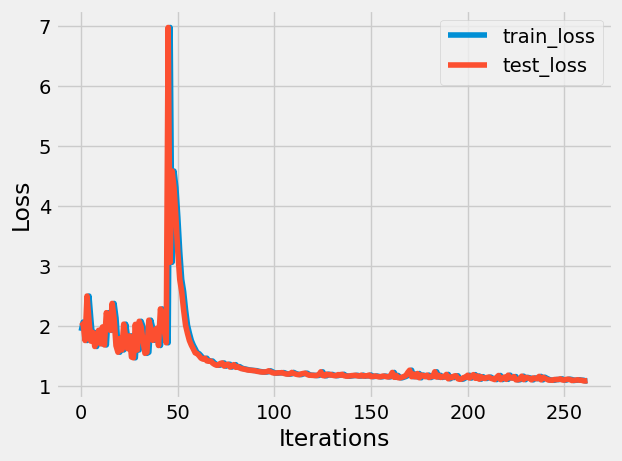

In [13]:
trainer.plot_history(100)

In [22]:
tuned_params.__dict__

{'params': {'act_dec1': 'relu',
  'act_dec2': 'leakyrelu',
  'act_dec3': 'leakyrelu',
  'act_dec4': 'tanh',
  'act_enc1': 'relu',
  'act_enc2': 'tanh',
  'act_enc3': 'relu',
  'batchnorm': 0,
  'leakyrelu': 0.023090296751797513,
  'lr': 0.003753923731050085,
  'mid_kernels': 8}}

[0/1000]	 loss: 6.9483 loss_test: 2.2387  lr: 0.0038  accurancy: 1.1586 
[1/1000]	 loss: 2.2387 loss_test: 2.7088  lr: 0.0038  accurancy: 1.4247 
[2/1000]	 loss: 2.7088 loss_test: 1.5220  lr: 0.0038  accurancy: 0.9119 
[3/1000]	 loss: 1.5220 loss_test: 1.2240  lr: 0.0038  accurancy: 0.5643 
[4/1000]	 loss: 1.2240 loss_test: 1.1972  lr: 0.0038  accurancy: 0.5166 
[5/1000]	 loss: 1.1972 loss_test: 1.1160  lr: 0.0038  accurancy: 0.4996 
[6/1000]	 loss: 1.1160 loss_test: 1.1064  lr: 0.0038  accurancy: 0.6338 
[7/1000]	 loss: 1.1064 loss_test: 1.0705  lr: 0.0038  accurancy: 0.4939 
[8/1000]	 loss: 1.0705 loss_test: 1.0033  lr: 0.0038  accurancy: 0.5152 
[9/1000]	 loss: 1.0033 loss_test: 1.0344  lr: 0.0038  accurancy: 0.6600 
[10/1000]	 loss: 1.0344 loss_test: 1.1829  lr: 0.0038  accurancy: 0.4934 
[11/1000]	 loss: 1.1829 loss_test: 1.0851  lr: 0.0038  accurancy: 0.4480 
[12/1000]	 loss: 1.0851 loss_test: 1.0152  lr: 0.0038  accurancy: 0.4982 
[13/1000]	 loss: 1.0152 loss_test: 1.0149  lr: 0

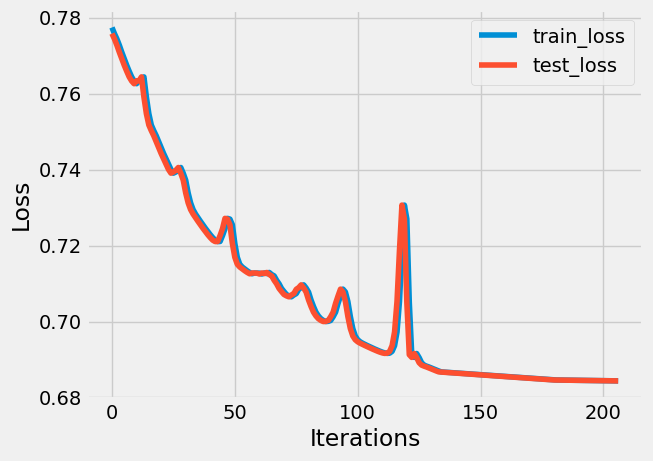

In [28]:
# trial = tuned_params
# trial = tuned_params
trainer = create_trainer(trial) 

trainer.scheduler = ReduceLROnPlateau(trainer.optimizer, factor=0.2, threshold=1e-2, patience=25)

trainer.train(1000, trial=trial, log=True)

trainer.plot_history(100)

In [ ]:

with torch.no_grad():
    cleaned = trainer.model(noised)

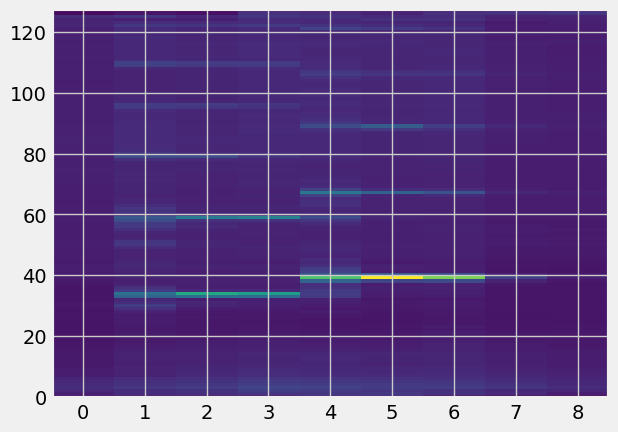

In [39]:
a = 8
x_prepared = x.cuda()[a:a + 1,].unsqueeze(1)
with torch.no_grad():
    x_predicted = trainer.model(x_prepared)

orig_wave = spectrogrammer.mel2wave_with_phase(x_prepared[0].cpu(), wavs[a])
predicted_wave = spectrogrammer.mel2wave_with_phase(x_predicted[0].cpu(), wavs[a])

display(Audio(wavs[a], rate=SAMPLE_RATE))
display(Audio(orig_wave.numpy(), rate=SAMPLE_RATE))
display(Audio(predicted_wave.numpy(), rate=SAMPLE_RATE))
plt.imshow((x_prepared[0][0] - x_predicted[0][0]).cpu(), origin="lower", aspect="auto") #, cmap="Greys")

In [51]:
(x_initial_gpu[0][0] - noised[0][0]).cpu()[:,4]

tensor([ 0.0000,  0.0802,  0.1829,  0.2715,  0.0879, -0.1447, -0.1163, -0.2758,
        -0.0214, -0.5481, -1.2333, -0.4696, -1.1906, -1.4247, -0.0823, -0.5343,
        -1.6881, -1.1896, -0.2284, -0.0524, -0.5607, -0.7738, -0.1667, -0.1973,
        -0.4599, -0.1297, -0.2605, -0.1820,  0.0467, -0.3178, -0.9913, -2.1537,
        -0.8566, -0.2070, -0.0079, -0.4611, -0.6330, -1.3257, -1.3615, -1.1484,
        -0.8437, -0.4064, -0.2675, -0.1034,  0.0350,  0.1220,  0.1550, -0.2539,
        -0.1308,  0.1587, -0.0251,  0.0796,  0.0835, -0.2039, -0.6141, -2.7139,
        -2.7680, -1.0132, -0.2252,  0.0751,  0.1064,  0.0070, -0.5191, -0.9130,
        -1.3855, -1.3584, -0.5614, -0.0380,  0.1561,  0.0743, -0.0555, -0.1317,
        -0.1955, -0.3901, -0.9063, -0.3525,  0.2324,  0.2656,  0.2165, -0.3530,
        -0.3148, -0.0851, -0.0374, -0.0945,  0.0685, -0.0764, -0.3830, -0.2706,
        -0.1789, -0.3254, -0.3080, -0.0289,  0.2330,  0.2812,  0.3106,  0.2675,
         0.0891,  0.0992,  0.1305,  0.00

In [140]:
noised.shape

torch.Size([1, 1, 128, 9])

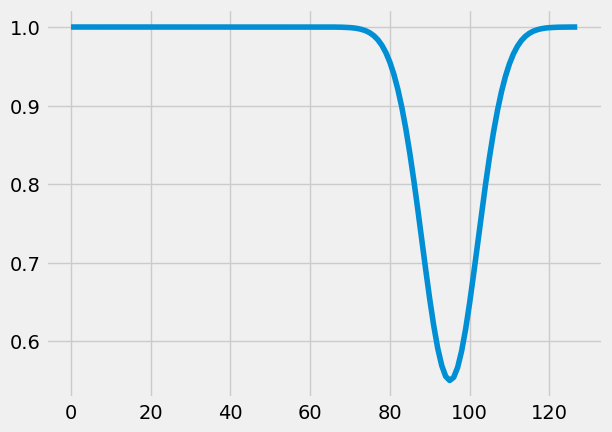

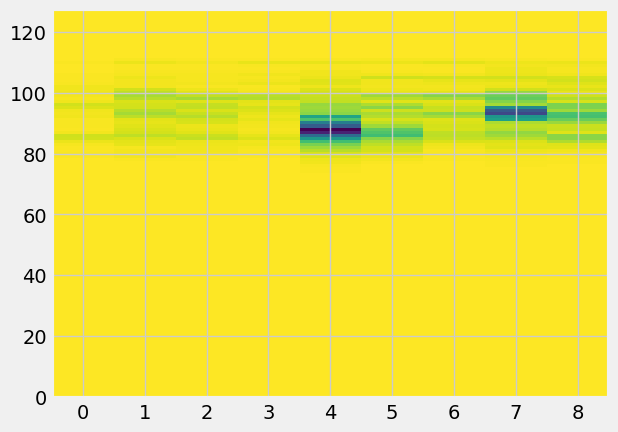

In [79]:
# centers = torch.rand((x.shape[0], ), device=x.device)
# centers = remap(centers, 0, 1, 32, N_MELS - 32)
filters = nd_based_filter(N_MELS, centers) # (N, N_MELS)
down_filters = 1 - 0.45 * filters
# return x * down_filters[:, None, :, None]
plt.plot(down_filters[0])
plt.show()

xx = x.unsqueeze(1)
noised = xx * down_filters[:, None, :, None]
plt.imshow(noised[0][0] - xx[0][0], origin="lower", aspect="auto")

In [74]:
x.unsqueeze(1).shape

torch.Size([7996, 128, 9])

In [65]:
down_filters[:, None, :, None]

tensor([[[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [0.9999],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        ...,


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]],


        [[[1.0000],
          [1.0000],
          [1.0000],
          ...,
          [1.0000],
          [1.0000],
          [1.0000]]]])

In [121]:
trainer.model.filter_coef

Parameter containing:
tensor(0.3701, device='cuda:0', requires_grad=True)

[0/1000]	 loss: 0.0096 loss_test: 0.0097  lr: 0.0026  fix_percent: 1.1400 noise: 0.0228 predicted_noise: 0.0260 
[1/1000]	 loss: 0.0096 loss_test: 0.0117  lr: 0.0026  fix_percent: 1.2884 noise: 0.0228 predicted_noise: 0.0294 
[2/1000]	 loss: 0.0114 loss_test: 0.0091  lr: 0.0026  fix_percent: 1.0785 noise: 0.0227 predicted_noise: 0.0245 
[3/1000]	 loss: 0.0092 loss_test: 0.0099  lr: 0.0026  fix_percent: 1.1451 noise: 0.0224 predicted_noise: 0.0257 
[4/1000]	 loss: 0.0098 loss_test: 0.0093  lr: 0.0026  fix_percent: 1.0687 noise: 0.0227 predicted_noise: 0.0242 
[5/1000]	 loss: 0.0094 loss_test: 0.0090  lr: 0.0026  fix_percent: 1.1026 noise: 0.0230 predicted_noise: 0.0253 
[6/1000]	 loss: 0.0093 loss_test: 0.0088  lr: 0.0026  fix_percent: 1.0522 noise: 0.0225 predicted_noise: 0.0237 
[7/1000]	 loss: 0.0093 loss_test: 0.0087  lr: 0.0026  fix_percent: 1.0373 noise: 0.0229 predicted_noise: 0.0237 
[8/1000]	 loss: 0.0085 loss_test: 0.0088  lr: 0.0026  fix_percent: 1.0303 noise: 0.0228 predicte

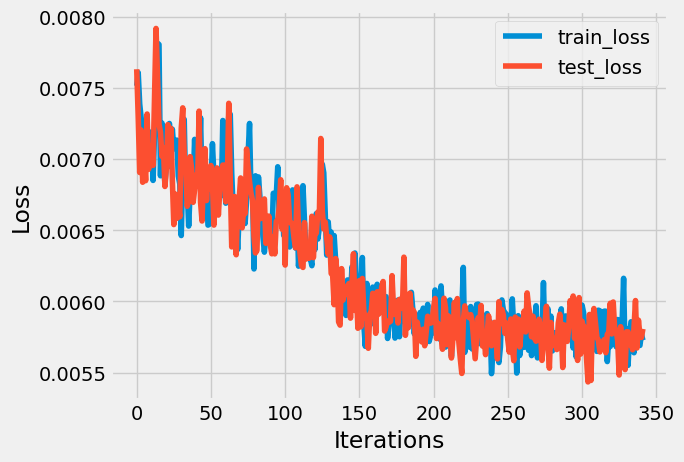

In [137]:
trial = tuned_params
trainer = create_trainer(trial) 
# trainer.scheduler=ReduceLROnPlateau(optimizerG, factor=0.2, threshold=1e-2, patience=50))

trainer.train(1000, trial=trial, log=True)

trainer.plot_history(100)

In [221]:
tuned_params.suggest_int("batchnorm", 1, 0, 1)

1

In [37]:
with torch.no_grad():
    x_pred = model(x_gpu)
x_pred = torch.squeeze(x_pred, dim=1)
print(x_pred.shape)
wave_pred = spectrogrammer.mel2wave_with_phase(x_pred[0], wavs[0])
display(Audio(wave_pred.cpu().numpy(), rate=SAMPLE_RATE))

torch.Size([100, 128, 9])


In [45]:
Audio(wavs[0].cpu().numpy() - wave_pred.cpu().numpy(), rate=SAMPLE_RATE)

In [51]:
plot_spectrogram(x_pred[0].cpu().numpy())

NameError: name 'x_pred' is not defined

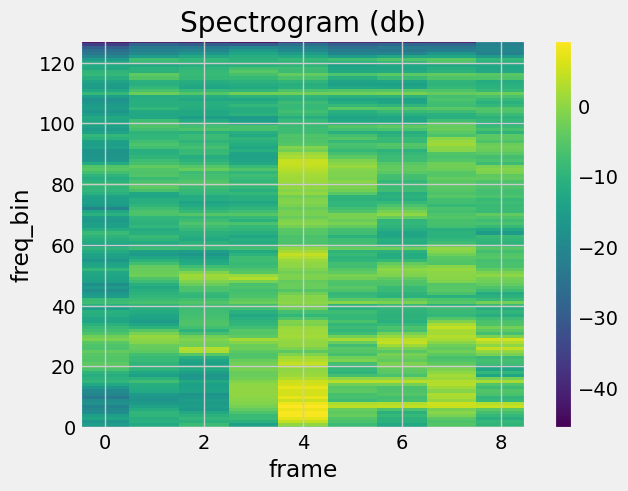

In [39]:
plot_spectrogram(x[0].cpu().numpy())

In [46]:
display(Audio(wavs[0], rate=SAMPLE_RATE))
wave = spectrogrammer.mel2wave(x[0])
display(Audio(wave.numpy(), rate=SAMPLE_RATE))

In [150]:
model = model_gpu.to("cpu")
x_pred = model(x)
wave_pred = spectrogrammer.mel2wave(x_pred)
wave_pred.shape

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [154]:
spectrogrammer.mel2wave(x).shape

KeyboardInterrupt: 

In [91]:
tensor

tensor([[-0.2018,  0.0599],
        [ 0.2664,  1.5481]])

In [55]:
torch.__version__

'1.12.1+cu116'

In [ ]:
for epoch in range(epochs):
    for i in x:
       
    #   # Reshaping the image to (-1, 784)
    #   image = image.reshape(-1, 28*28)
       
      # Output of Autoencoder
      reconstructed = model(x)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, x)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
       
      # Storing the losses in a list for plotting
      losses.append(loss)
      print(loss)
    outputs.append((epochs, image, reconstructed))